In [1]:
from src import Prep
from src.Time_Series_Helper_Funcs import *

In [ ]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV,  KFold
from sklearn.metrics import f1_score, r2_score, mean_squared_error, make_scorer, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import tscv
from tscv import *
import numpy as np
import pandas as pd 
import pyramid
from pmdarima.arima import auto_arima

# from src.Trend_Season_plots import *
# # visualization packages
# %matplotlib inline
# import seaborn as sns
# sns.set()
# import plotly.express as px
# plt.style.use('ggplot')
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6


import warnings
warnings.filterwarnings('ignore')


In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload

In [48]:
%autoreload

Elapsed time is 0.000002 seconds.


In [49]:
df = Prep.prep()

1 of 11 |    Reading in first dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
Elapsed time is 30.723618 seconds.
2 of 11 |    Reading in second dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
Elapsed time is 2.189462 seconds.
3 of 11 |    Concatenating datasets together
4 of 11 |    Refining to only RES Customer Segment
5 of 11 |    Cleaning up column names
6 of 11 |    Sorting values by installation_date
7 of 11 |    Assigning installation_date as index
8 of 11 |    Replacing all null values with median values from same year
9 of 11 |    Adusting prices for inflation
Elapsed time is 47.875885 seconds.
10 of 11|    Creating target variable: cost_per_watt
11 of 11|    Removing > 1600 outliers above $25 per watt
Prep complete 
 ------

In [50]:
y, lag_cost, solar_model = shortened_timeline(df)[0], shortened_timeline(df)[1], shortened_timeline(df)[2]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.737e+04
Date:                Tue, 17 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:09:07   Log-Likelihood:                -320.64
No. Observations:                 885   AIC:                             649.3
Df Residuals:                     881   BIC:                             668.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0235      0.035      0.676      0.4

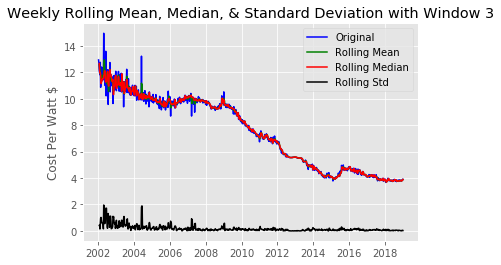

Results of Dickey-Fuller Test:
Test Statistic                  -1.323589
p-value                          0.618312
#Lags Used                      21.000000
Number of Observations Used    866.000000
Critical Value (1%)             -3.437924
Critical Value (5%)             -2.864883
Critical Value (10%)            -2.568550
dtype: float64


In [51]:
rolling_plot(y)
plt.show()
test_stationarity(y)

ADF p-value: 0.00
Achieved stationarity! Reject ADF H0.


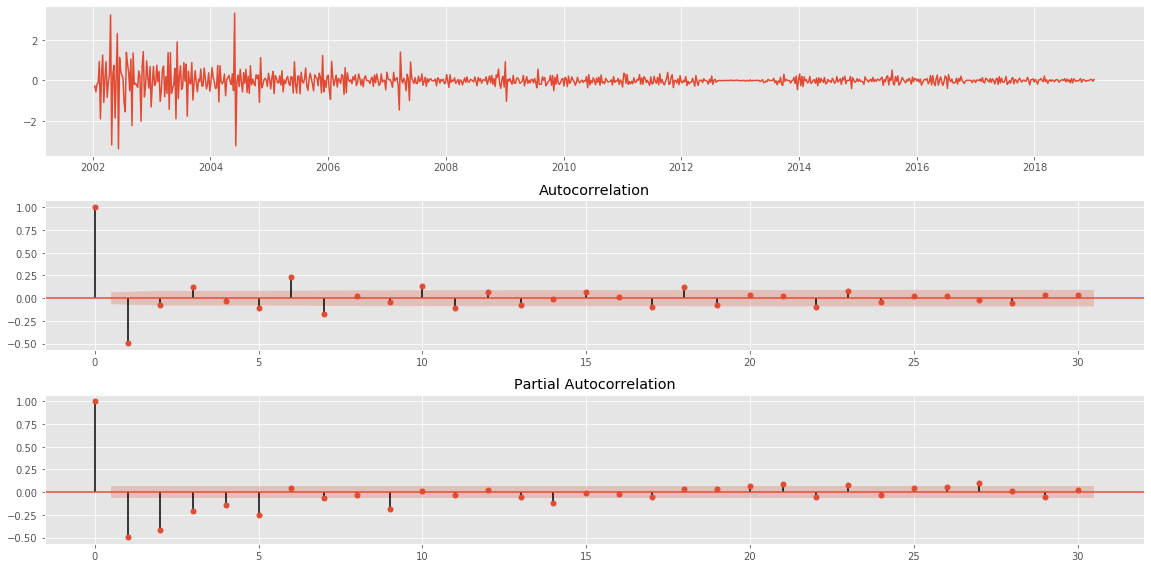

In [41]:
weekly_differences = get_differences(y)
wdn = np.array(weekly_differences.dropna())

In [ ]:

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
stationarity check
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
plot_acf(apt_rawdata.calib_usage, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(apt_rawdata.calib_usage,lags=40,ax=ax2)


In [42]:
import os

In [ ]:
os.getcwd

In [45]:
from pytictoc import TicToc

In [52]:
df

,system_size,total_installed_price,customer_segment,date,adj_installed_price,cost_per_watt
installation_date,,,,,,
1998-01-30,4.251500,17439.0,RES,1998-01-30,27838.84,6.55
1998-04-08,2.331600,30941.0,RES,1998-04-08,49119.27,21.07
1998-04-30,4.181100,17439.0,RES,1998-04-30,27684.65,6.62
1998-07-07,2.282400,24500.0,RES,1998-07-07,38727.26,16.97
1998-07-10,3.113265,17439.0,RES,1998-07-10,27565.91,8.85
...,...,...,...,...,...,...
2018-12-31,5.760000,22000.0,RES,2018-12-31,22590.03,3.92
2018-12-31,4.410000,21610.0,RES,2018-12-31,22189.57,5.03
2018-12-31,8.640000,45958.6,RES,2018-12-31,47191.20,5.46


In [89]:
ndf = pd.DataFrame(df['cost_per_watt'].resample('D').median())
lag_cost = (pd.concat([ndf.shift(i) for i in range(4)], axis=1, keys=['y'] + ['Lag%s' % i for i in range(1, 4)])).dropna()
solar_model = smf.ols('y ~ Lag1 + Lag2 + Lag3', data=lag_cost).fit()
print(solar_model.summary())
print(ndf, lag_cost, solar_model) 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     4842.
Date:                Tue, 17 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:09:12   Log-Likelihood:                -9154.7
No. Observations:                5123   AIC:                         1.832e+04
Df Residuals:                    5119   BIC:                         1.834e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.057      7.935      0.0

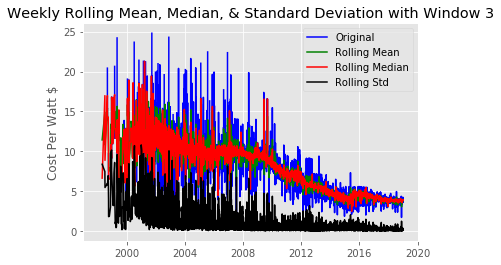

In [54]:
rolling_plot(ndf)

In [55]:
ndfn = ndf.dropna()

In [56]:
test_stationarity(ndfn)

Results of Dickey-Fuller Test:
Test Statistic                   -1.561009
p-value                           0.503144
#Lags Used                       33.000000
Number of Observations Used    6151.000000
Critical Value (1%)              -3.431414
Critical Value (5%)              -2.862010
Critical Value (10%)             -2.567020
dtype: float64


ADF p-value: 0.00
Achieved stationarity! Reject ADF H0.


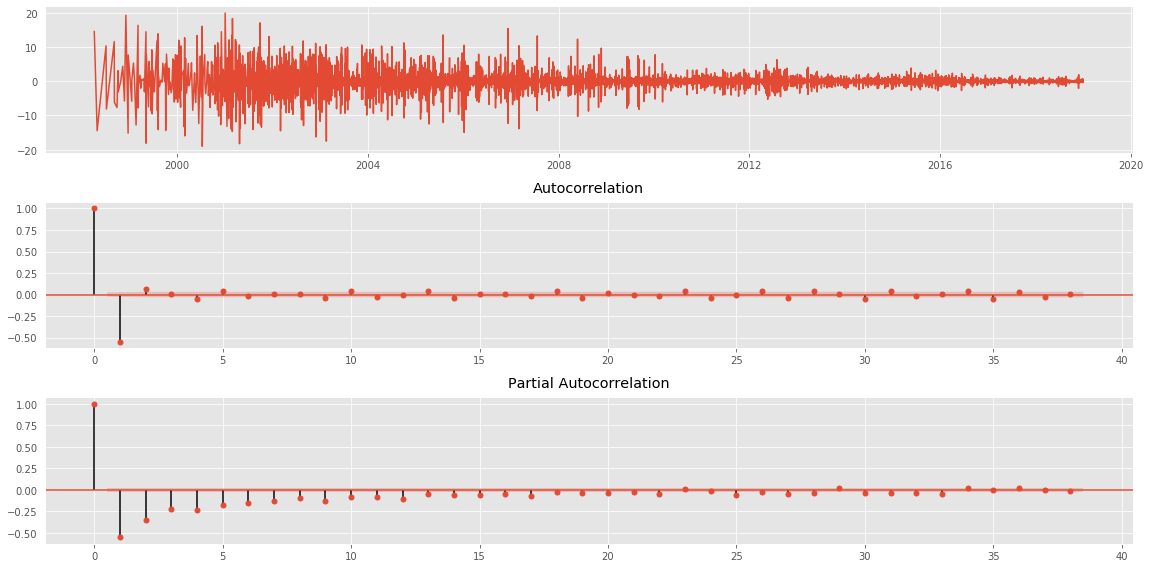

In [75]:
daily_differences = pd.DataFrame(get_differences(ndfn))

ADF p-value: 0.00
Achieved stationarity! Reject ADF H0.


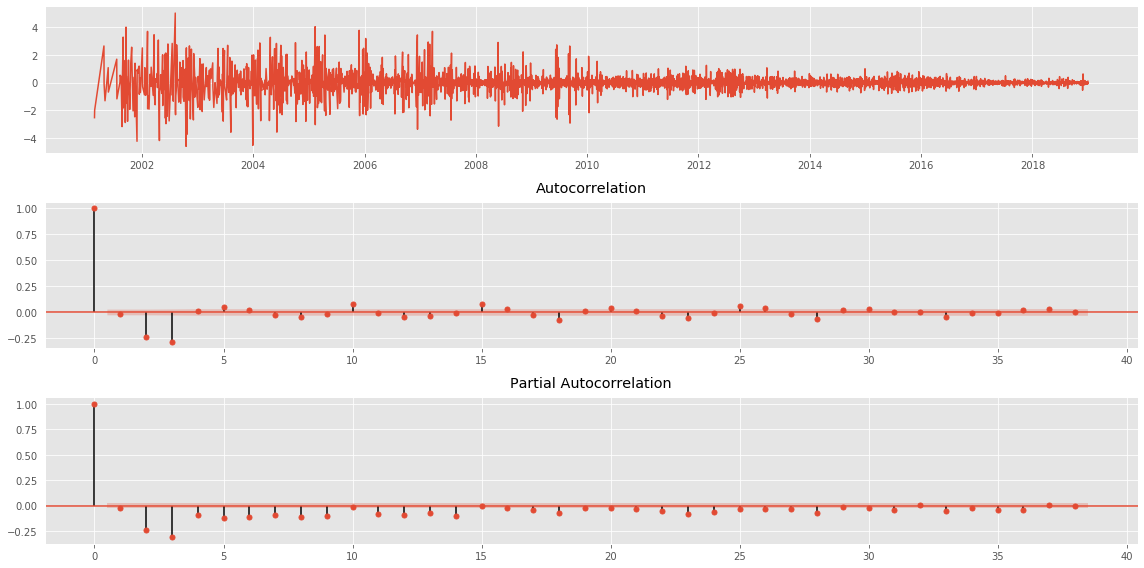

In [78]:
daily_differences = pd.DataFrame(get_differences(solar_model.fittedvalues))

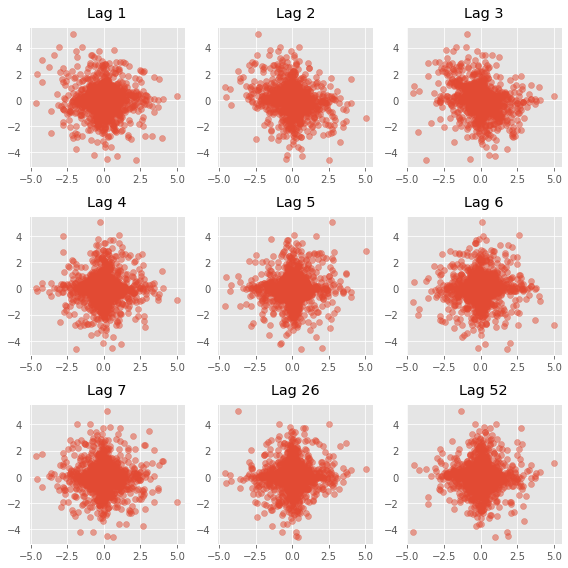

In [79]:
plot_ac_scat(daily_differences)

In [62]:
from src.TSA import * 

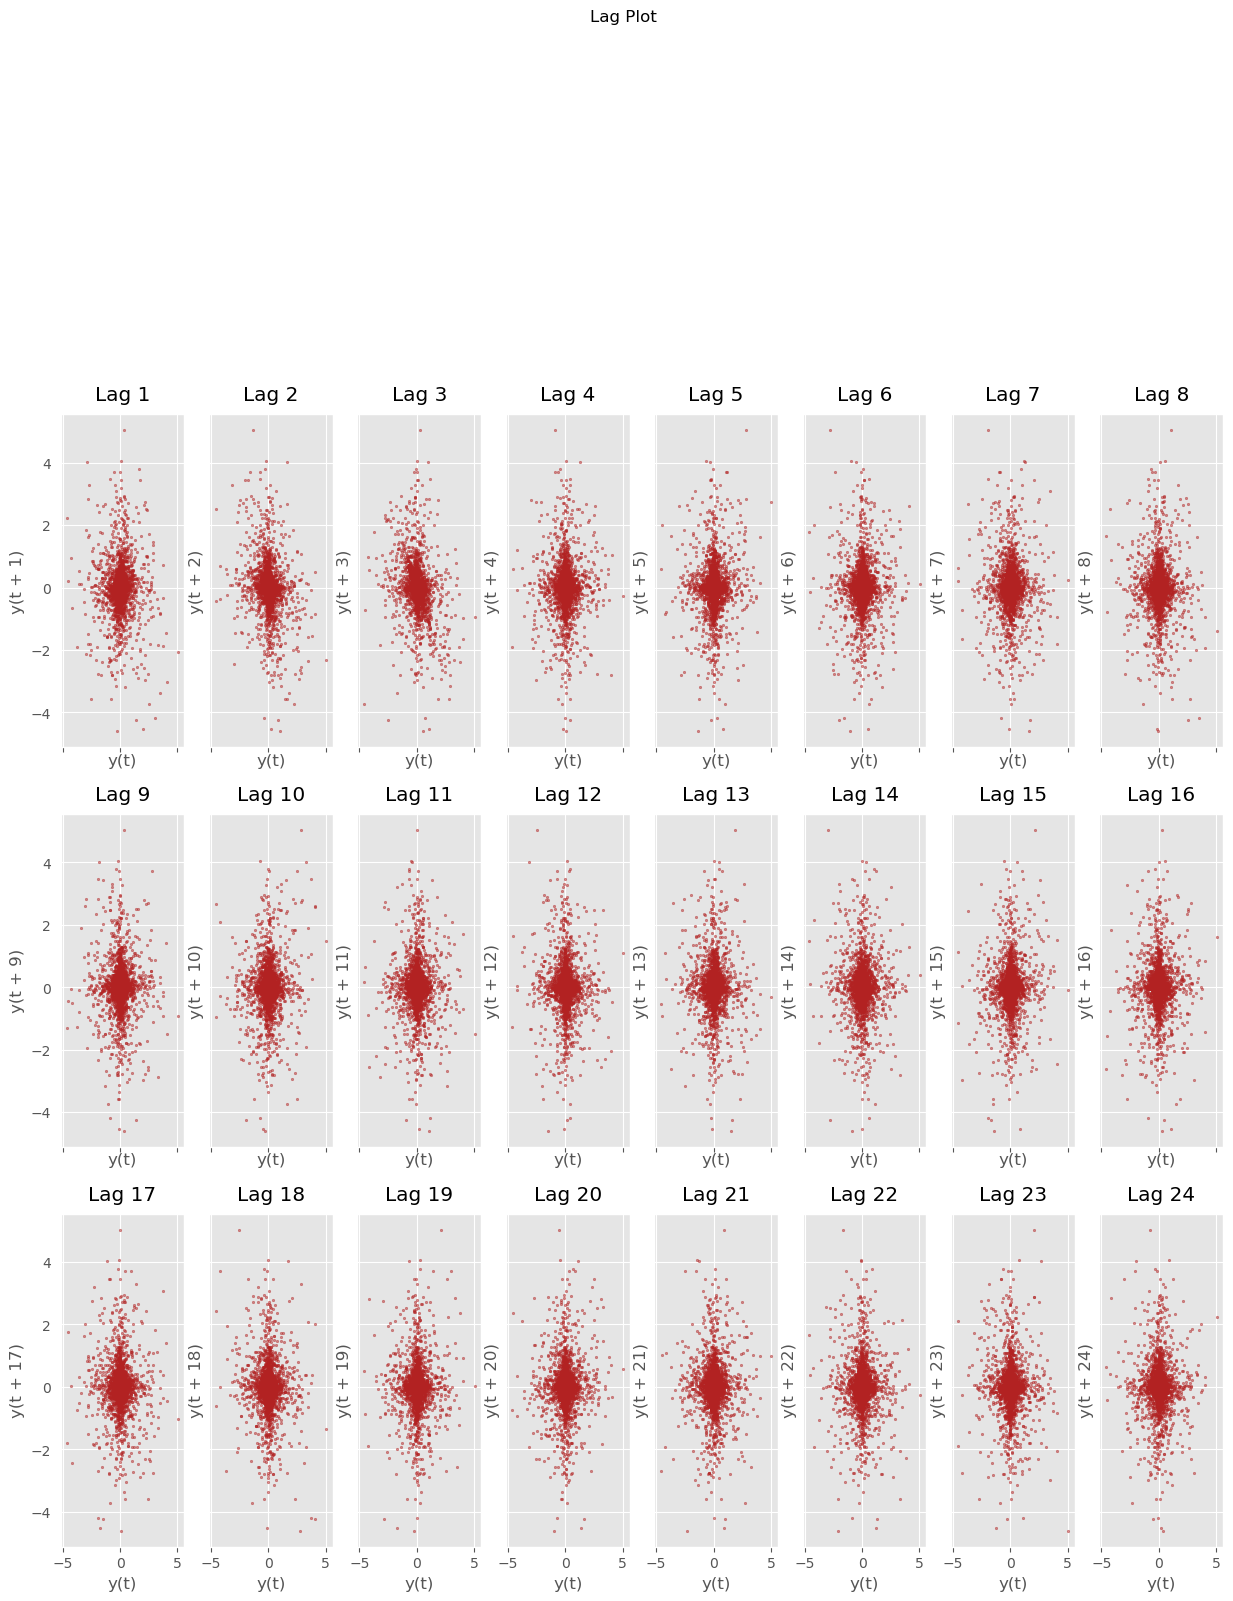

In [80]:
lag_plots(daily_differences)

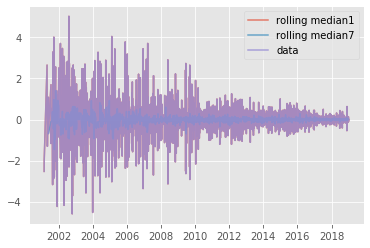

In [81]:
ywnd = pd.DataFrame(daily_differences).dropna()
rollingmediand1 = ywnd.rolling(window=1).median()
rollingmediand7 = ywnd.rolling(window=7).median()
plt.plot(rollingmediand1, alpha=0.7, label='rolling median1')
plt.plot(rollingmediand7, alpha=0.7, label='rolling median7')
plt.plot(ywnd, alpha=0.8, label='data')
plt.legend(loc='best')
plt.show()


In [82]:
daily = pd.DataFrame(daily_differences.copy())

In [83]:
predict = pd.DataFrame(daily.loc[daily.index.year>2017])

In [90]:
predict['cost_1dayago'] = daily.shift(1)
predict['cost_1weekago'] = daily.shift(7)

In [93]:
predict.rename(columns={0:'cost_per_watt'},inplace=True)

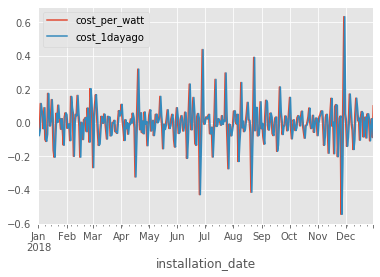

In [99]:
predict[['cost_per_watt', 'cost_1dayago']].plot()

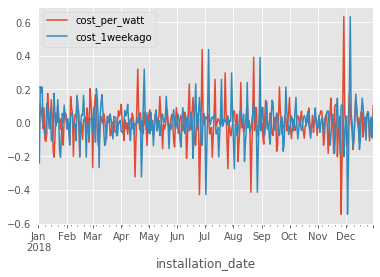

In [100]:
predict[['cost_per_watt', 'cost_1weekago']].plot()

In [104]:
%autoreload

In [101]:
precision(predict,'cost_1dayago','cost_per_watt')
precision(predict,'cost_1weekago','cost_per_watt')

cost_1dayago [Rsquared: -0.54 MAE: 0.09 MSE: 0.02 RMSE: 0.13 MAPE: 161.15 MAPE_adjust: 9.79 sMAPE: 558.33 ]
cost_1weekago [Rsquared: -1.01 MAE: 0.1 MSE: 0.02 RMSE: 0.15 MAPE: 397.63 MAPE_adjust: 10.86 sMAPE: -235.21 ]


In [107]:
precision(predict,'cost_1dayago','cost_per_watt')
precision(predict,'cost_1weekago','cost_per_watt')

cost_1dayago [Rsquared: -0.54 
 MAE: 0.09 
 MSE: 0.02 
 RMSE: 0.13 
 MAPE: 161.15 
 MAPE_adjust: 9.79 
 sMAPE: 558.33 ]
cost_1weekago [Rsquared: -1.01 
 MAE: 0.1 
 MSE: 0.02 
 RMSE: 0.15 
 MAPE: 397.63 
 MAPE_adjust: 10.86 
 sMAPE: -235.21 ]


In [ ]:
train = y[:710]
test = y[710:]

y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['cost_per_watt'].rolling(3).mean().iloc[-1]
y_hat_avg['moving_avg_forecastmed'] = train['cost_per_watt'].rolling(3).median().iloc[-1]

plt.figure(figsize=(10,6))
plt.title('Prediction by Mean/Median with Various Rolls')
plt.plot(train['cost_per_watt'], label='Train')
plt.plot(test['cost_per_watt'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast Mean 3 Roll')
#plt.plot(y_hat_avg['moving_avg_forecastroll52'], label='Moving Average Forecast Mean 52 Roll')
plt.plot(y_hat_avg['moving_avg_forecastmed'], label='Moving Average Forecast  Median 3 Roll')
#plt.plot(y_hat_avg['moving_avg_forecastmed52'], label='Moving Average Forecast  Median 52 Roll')
plt.legend(loc='best')
plt.show()


rms_mean = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecast))
rms_med = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecastmed))
print('RMS of mean= ' , rms_mean)
print('RMS of median= ' , rms_med)